<a href="https://colab.research.google.com/github/michalsn13/Predict_disaster_tweets/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NN+NLP Project : Predict disaster tweets
by Michał Dąbrowski, Pranav Kelkar & Adrian Rodriguez
---

## Timeline

- [x] (8 Jun) Preprocess data - Find class distributions, fix errors, etc
    - [x] Fix duplicate entries (some entries have same text but different labels)
    - [x] Add keywords for all possible tweets?
    - [x] Add locations for all possible tweets?
- [x] (5 Jun) Find classification models as baselines *(add here if you can think of any)*
    - Simple if-else statements by looking at the data? (for eg, `if "earthquake" in sentence: return True`)
    - Logistic Regression
    - Naïve Bayes
    - Random Forest(on "keyword" and "location")
    - Clustering (on "keyword" and "location")
    - Linear Support Vector Machine
- [x] (12 Jun) Implement baseline classification models
    - [x] Naïve Bayes classifier
    - [x] Random Forest on `keyword` and `location` (requires data preprocessing)
    - [x] XG Boost
    - [x] Logistic Regression
- [ ] (12 Jun) Implement baseline NLP models
    - [x] Reused NLP task
    - [x] (12 Jun) Choose a text classification model from [Huggingface](http://huggingface.co)
- [x] (14 Jun) Prepare Milestone Presentation
- [x] (24 Jun) Implement LSTM
- [x] (24 Jun) Implement RNN
- [x] (24 Jun) Implement Transfer Learning with BERT
- [x] (27 Jun) Prepare Final Presentation and Code



## Imports

In [ ]:
!pip install torchtext==0.10.0
!python -m spacy download en_core_web_lg
!pip install transformers

In [ ]:
import html
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sb
import sklearn
import spacy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from spacy.util import load_model_from_init_py
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
#from transformers import BertTokenizer
#from transformers import BertModel
#from transformers import pipeline
from torch.optim import Adam
#from torchtext.legacy import data
from tqdm import tqdm

## Loading data

In [ ]:
!gdown --id 1-Kxi2yBnu599g3q2vd-wy_OGzhglbShz
!gdown --id 196C3_dGtnPPsx81Mh0o7ciurfIlfLkXX
!gdown --id 1gNmxORKmFDdJjJpnMZvhytNtj_M-iEAe

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1-Kxi2yBnu599g3q2vd-wy_OGzhglbShz
To: /content/train.csv
100% 988k/988k [00:00<00:00, 152MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=196C3_dGtnPPsx81Mh0o7ciurfIlfLkXX
To: /content/test.csv
100% 421k/421k [00:00<00:00, 131MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.

In [ ]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [ ]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


## Data cleaning

Some texts occur multiple times, so we delete the duplicates and set the target of the remaining ones as the rounded mean target of all occurrences. If the mean was 0.5 (eg. if we have 2 occurrences, one with target==1 and another with target==0), we delete all occurrences of that text because we cannot decide what target should it have.

In [ ]:
multiples = train_df.loc[:,['id','text','target']].groupby('text').agg({"id": lambda x: x.nunique(),"target": lambda x: sum(x)/len(x)})
multiples = multiples[multiples['id']>1] #more than 1 occurance of given text
to_delete = multiples[multiples['target']==0.5] #texts with exactly 50% of occurances having target==1 (hard to qualify)

print(f"Deleted {to_delete['id'].sum()} rows due to unclear target.") 
train_df = train_df[~train_df['text'].isin(to_delete.index)]
multiples = multiples[multiples['target']!=0.5]

Deleted 24 rows due to unclear target.


In [ ]:
multiples['rounded_target'] = multiples['target'].round()
print(f"We deleted {multiples['id'].sum()-multiples['id'].count()} rows of duplicate texts.")
train_df = train_df.drop_duplicates(subset=['text'])
for t in multiples.index:
    train_df.loc[train_df['text']==t,'target']=float(multiples.loc[multiples.index==t,'rounded_target'])

We deleted 96 rows of duplicate texts.


Fixing html escape symbols (fe '%20' instead of ' ')

In [ ]:
train_df = train_df.apply(lambda x: html.unescape(x))
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


Deleting tags and special characters from data

In [ ]:
#delete tags
train_df['text_clean'] = train_df['text'].replace('@[a-zA-Z0-9-_]+','', regex=True)
train_df['location_clean'] = train_df['location'].replace('@[a-zA-Z0-9-_]+','', regex=True)
train_df['keyword'] = train_df['keyword'].replace('@[a-zA-Z0-9-_]+','', regex=True)
#delete links
train_df['text_clean'] = train_df['text_clean'].replace(r"\S*https?:\S*",'',regex=True)
def special_char_delete(line,non_special=r"[^a-zA-Z0-9 \_\-\']"):
    if not pd.isnull(line):
        r = re.compile(non_special)
        return r.sub('', line)
    return line
#delete special characters, lower all characters and strip extra spaces
train_df['text_clean'] = train_df['text_clean'].apply(special_char_delete).str.lower().str.strip()
train_df['location_clean'] = train_df['location'].apply(special_char_delete).str.lower().str.strip()
train_df['keyword'] = train_df['keyword'].apply(special_char_delete).str.lower().str.strip()

### Adding extra columns
In this section, we create more columns just based on the given text, in hopes of creating useful features.

####Hashtags column

In [ ]:
def hash_finder(x):
    result=re.findall(r'#([a-zA-Z0-9]+)',x)
    if result:
        return "_".join(result)
    else:
        return np.NaN
train_df['hashtags']=train_df['text'].str.lower().apply(hash_finder)

####New keywords columns

Keywords (using pre-filled)

Here we add keywords to the NaN column by finding already existing keywords in the current text.

In [ ]:
no_keyword = train_df['keyword'].isna()

In [ ]:
def finder(text,words_from):
    result="-".join(list(set(text).intersection(words_from)))
    if result:
        return result
    else:
        return np.NaN

In [ ]:
all_keywords = set(train_df['keyword'].dropna()).intersection(set([''])) #Unique keywords

In [ ]:
train_df['keyword_text'] = train_df['keyword']
train_df.loc[no_keyword,'keyword_text'] = train_df['text_clean'].apply(finder,words_from=all_keywords)[no_keyword]

Keywords (pre-filled + hashtags)
Here we also use the hashtags in each Tweet as a keyword, only for those that don't have a keyword still

In [ ]:
no_keyword_text = train_df['keyword_text'].isna()

In [ ]:
train_df['keyword_text_with_hash'] = train_df['keyword_text']
train_df.loc[no_keyword,'keyword_text_with_hash'] = train_df.loc[no_keyword_text,'hashtags']

#### New location columns

Location filled with spaCy

`spaCy` has a Named Entity Recognition feature that recognises locations (among other entities) in a given text. We use this to fill in missing values of the location column in a text.

In [ ]:
no_location = train_df['location_clean'].isna()

In [ ]:
nlp = load_model_from_init_py('/usr/local/lib/python3.7/dist-packages/en_core_web_lg/__init__.py')
nlp = spacy.load('en_core_web_lg')
def spacy_finder(text):
    doc = nlp(text)
    result=[]
    for ent in doc.ents:
        if (ent.label_ == 'GPE' or ent.label_ == 'LOC') and not re.findall(r'[0-9]+',ent.text): #no numbers
            result.append(ent.text.lower().strip())
    if result:
        for loc in result: #first one to satisfy condition
            if len(loc)>=3 or loc=='us': #not too short to be actual location, unless its the US
                return loc
    return np.NaN

In [ ]:
train_df['location_with_spacy'] = train_df['location_clean']
spacy_results=train_df['text_clean'].apply(spacy_finder)
train_df.loc[no_location,'location_with_spacy'] = spacy_results[no_location]

Location (using pre-filled)

Here we only use the pre-filled location columns, and see if the text has one of those locations

In [ ]:
all_locations = set(train_df['location_clean'].dropna()).difference(set([''])) #Unique locations

In [ ]:
train_df['location_text'] = train_df['location_clean']
train_df.loc[no_location,'location_text'] = train_df['text_clean'].apply(finder,words_from=all_locations)[no_location]

Location (pre-filled + spaCy)

In [ ]:
no_location_text = train_df['location_text'].isna()

In [ ]:
train_df['location_text_with_spacy'] = train_df['location_text']
train_df.loc[no_location_text,'location_text_with_spacy'] = spacy_results[no_location_text]

#### Data PreProcessing Results

In [ ]:
train_df.head()

,id,keyword,location,text,target,text_clean,location_clean,hashtags,keyword_text,keyword_text_with_hash,location_with_spacy,location_text,location_text_with_spacy
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...,NaN,earthquake,NaN,earthquake,NaN,NaN,NaN
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,all residents asked to 'shelter in place' are ...,NaN,NaN,NaN,NaN,NaN,','
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...,NaN,wildfires,NaN,wildfires,california,NaN,california
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby alaska as s...,NaN,alaska_wildfires,NaN,alaska_wildfires,NaN,NaN,NaN


## Data Analysis on Cleaned Training Data Set

Number of NaNs

In [ ]:
1-train_df.isna().sum()/train_df.shape[0]

id                          1.000000
keyword                     0.992526
location                    0.669291
text                        1.000000
target                      1.000000
text_clean                  1.000000
location_clean              0.669291
hashtags                    0.226745
keyword_text                0.992526
keyword_text_with_hash      0.995062
location_with_spacy         0.725477
location_text               0.813292
location_text_with_spacy    0.845189
dtype: float64

Number of real catastrophies:

In [ ]:
train_df.value_counts('target',dropna=False)

target
0    4302
1    3191
dtype: int64

Extra data sets for real catastrophies and fake ones:

In [ ]:
train_df0 = train_df[train_df['target']==0]
train_df1 = train_df[train_df['target']==1]

Top 15 locations based on number of occurances in real/fake catastrophies tweets:

In [ ]:
counter0 = train_df0.value_counts('location',dropna=False)
print(f'Unique phrases with target==0: {len(counter0)}')
print(counter0.head(15))
counter1 = train_df1.value_counts('location',dropna=False)
print(f'\nUnique phrases with target==1: {len(counter1)}')
print(counter1.head(15))

Unique phrases with target==0: 2134
location
NaN                1438
New York             55
USA                  37
London               29
United States        23
Los Angeles, CA      18
Canada               16
Kenya                15
Everywhere           12
Florida              11
UK                   11
United Kingdom       10
California           10
NYC                  10
London, England       9
dtype: int64

Unique phrases with target==1: 1497
location
NaN                 1040
USA                   67
United States         27
Mumbai                18
India                 17
Nigeria               17
London                16
New York              16
Washington, DC        15
UK                    15
Canada                13
Worldwide             12
Australia              9
Chicago, IL            9
Washington, D.C.       9
dtype: int64


Probs of tweet with given location being true:

In [ ]:
train_df.loc[:,['location','target']].groupby('location',dropna=False).agg({'target':['count','mean']}).sort_values(('target','count'),ascending=False)

target          
                              count      mean
location                                     
NaN                            2478  0.419693
USA                             104  0.644231
New York                         71  0.225352
United States                    50  0.540000
London                           45  0.355556
...                             ...       ...
Huntley, IL                       1  0.000000
Huntsville AL                     1  1.000000
Huntsville, Alabama               1  1.000000
Hustletown                        1  1.000000
Middle Earth / Asgard / Berk      1  1.000000

[3323 rows x 2 columns]

Top 15 keywords based on number of occurances in real/fake catastrophies tweets:

In [ ]:
counter0 = train_df0.value_counts('keyword',dropna=False)
print(f'Unique phrases with target==0: {len(counter0)}')
print(counter0.head(15))
counter1 = train_df1.value_counts('keyword',dropna=False)
print(f'\nUnique phrases with target==1: {len(counter1)}')
print(counter1.head(15))

Unique phrases with target==0: 219
keyword
body20bags     40
harm           37
armageddon     37
wrecked        36
deluge         36
ruin           36
siren          35
explode        35
fear           35
twister        35
screaming      34
panic          34
traumatised    33
crush          33
blaze          33
dtype: int64

Unique phrases with target==1: 221
keyword
outbreak             38
NaN                  37
wreckage             37
debris               37
oil20spill           37
typhoon              35
derailment           33
evacuated            32
razed                31
nuclear20disaster    31
suicide20bombing     31
suicide20bomber      30
earthquake           30
rescuers             29
bridge20collapse     29
dtype: int64


Probs of tweets with given keyword being true:

In [ ]:
train_df.loc[:,['keyword','target']].groupby('keyword').agg({'target':['count','mean']}).sort_values(('target','mean'),ascending=False)

target          
            count      mean
keyword                    
derailment     33  1.000000
wreckage       37  1.000000
debris         37  1.000000
outbreak       39  0.974359
oil20spill     38  0.973684
...           ...       ...
body20bag      33  0.030303
blazing        34  0.029412
ruin           37  0.027027
body20bags     41  0.024390
aftershock     32  0.000000

[221 rows x 2 columns]

Top 15 hashtags based on number of occurances in real/fake catastrophies tweets:

In [ ]:
counter0 = train_df0.value_counts('hashtags',dropna=False)
print(f'Unique phrases with target==0: {len(counter0)}')
print(counter0.head(15))
counter1 = train_df1.value_counts('hashtags',dropna=False)
print(f'\nUnique phrases with target==1: {len(counter1)}')
print(counter1.head(15))

Unique phrases with target==0: 709
hashtags
NaN                                     3433
hot_prebreak_best                         17
gbbo                                      11
nowplaying                                10
beyhive                                    8
directioners                               7
animalrescue                               7
dubstep_trapmusic_dnb_edm_dance_ices       5
handbag_womens                             5
rt                                         5
soundcloud                                 5
irandeal                                   4
np                                         4
emmerdale                                  4
lgbt                                       4
dtype: int64

Unique phrases with target==1: 661
hashtags
NaN                  2361
hot_prebreak_best      13
news                   12
earthquake              8
hiroshima               8
worldnews               8
wx                      7
antioch                 6
okwx           

Probs of tweets with given hashtags being true:

In [ ]:
train_df.loc[:,['hashtags','target']].groupby('hashtags').agg({'target':['count','mean']}).sort_values(('target','count'),ascending=False)

target          
                                         count      mean
hashtags                                                
hot_prebreak_best                           30  0.433333
news                                        16  0.750000
gbbo                                        12  0.083333
nowplaying                                  11  0.090909
hiroshima                                    8  1.000000
...                                        ...       ...
govt_ethical_usa                             1  0.000000
gop_potus_irandeal_isis                      1  1.000000
gop_disabledveterans_thepartyofmeanness      1  0.000000
goodbye                                      1  0.000000
zippoline_moveit                             1  0.000000

[1315 rows x 2 columns]

In [ ]:
train_df_add = train_df.copy() #Copy of train data set for adding analyses columns

Words counter for real/fake disaster tweets

word_count           
             mean        var
target                      
0       14.681079  37.967552
1       15.141962  25.884229

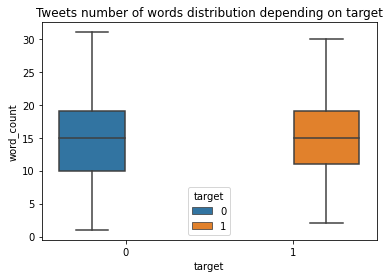

In [ ]:
train_df_add['word_count'] = train_df['text'].str.split().apply(len)
sb.boxplot(data=train_df_add, x='target', y="word_count", hue='target').set_title("Tweets number of words distribution depending on target")
train_df_add.loc[:,['word_count','target']].groupby('target').agg({'word_count':['mean','var']})

CAPITAL LETTERS percentage for real/fake disastert tweets:

capital_letters_percentage          
                             mean       var
target                                     
0                        0.097194  0.014039
1                        0.101175  0.008348

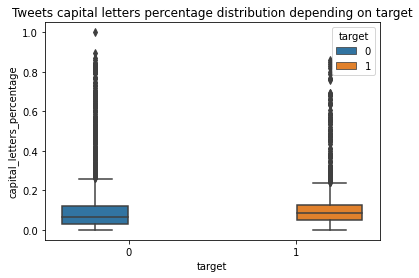

In [ ]:
train_df_add['capital_letters_percentage'] = train_df['text'].apply(lambda x: len(re.findall(r'[A-Z]',x))/len(x))
sb.boxplot(data=train_df_add, x='target', y="capital_letters_percentage", hue='target').set_title("Tweets capital letters percentage distribution depending on target")
train_df_add.loc[:,['capital_letters_percentage','target']].groupby('target').agg({'capital_letters_percentage':['mean','var']})

Lengths of real/fake disastert tweets:

length            
             mean         var
target                       
0        9.105067  119.277031
1       10.774365   92.599230

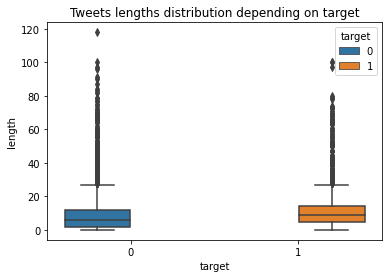

In [ ]:
train_df_add['length'] = train_df['text'].apply(lambda x: len(re.findall(r'[A-Z]',x)))
g=sb.boxplot(data=train_df_add,x='target',y="length",hue='target')
g.set_title("Tweets lengths distribution depending on target")
train_df_add.loc[:,['length','target']].groupby('target').agg({'length':['mean','var']})

exclamation               
              mean       var  sum
target                           
0         0.193166  0.453494  831
1         0.101536  0.290001  324

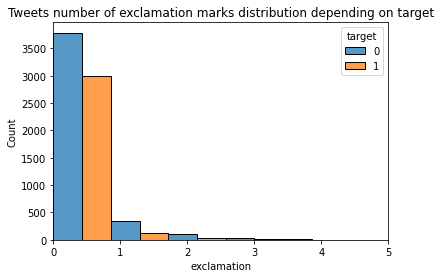

In [ ]:
train_df_add['exclamation'] = train_df['text'].apply(lambda x: len(re.findall(r'!',x)))
g = sb.histplot(data=train_df_add, x="exclamation", hue='target', multiple="dodge")
g.set_title("Tweets number of exclamation marks distribution depending on target")
g.set_xlim(0,5)
train_df_add.loc[:,['exclamation','target']].groupby('target').agg({'exclamation':['mean','var','sum']})

## Baseline Classification Models

### Splitting and vectorizing Data

Since the test dataset actually has no labels, we split train data into training and testing.

In [ ]:
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5, stop_words="english")
X = vectorizer.fit_transform(train_df.text)
Xc = vectorizer.fit_transform(train_df.text_clean)
Y = train_df.target

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42, stratify=Y)
Xc_train, Xc_test, Yc_train, Yc_test = train_test_split(Xc, Y, test_size=0.1, random_state=42, stratify=Y)

### Naïve Bayes Model

For training, we use the `sklearn` library for Naïve Bayes classifier

In [ ]:
nbc = MultinomialNB(alpha=1)
nbc.fit(X_train, Y_train)

nbc2 = MultinomialNB(alpha=1)
nbc2.fit(Xc_train, Yc_train)

MultinomialNB(alpha=1)

In [ ]:
nbc_pred = nbc.predict(X_test)
nbc_pred2 = nbc2.predict(Xc_test)

In [ ]:
score = metrics.accuracy_score(Y_test, nbc_pred)
print('Using Text column without cleaning')
print("accuracy:   %0.3f" % score)

print("classification report:")
print(metrics.classification_report(Y_test, nbc_pred))

print("confusion matrix:")
print(metrics.confusion_matrix(Y_test, nbc_pred))
print()

print("Using Text column after cleaning")
score2 = metrics.accuracy_score(Yc_test, nbc_pred2)
print("accuracy:   %0.3f" % score2)

print("classification report:")
print(metrics.classification_report(Yc_test, nbc_pred2))

print("confusion matrix:")
print(metrics.confusion_matrix(Yc_test, nbc_pred2))

Using Text column without cleaning
accuracy:   0.809
classification report:
              precision    recall  f1-score   support

           0       0.79      0.91      0.85       431
           1       0.85      0.67      0.75       319

    accuracy                           0.81       750
   macro avg       0.82      0.79      0.80       750
weighted avg       0.81      0.81      0.81       750

confusion matrix:
[[393  38]
 [105 214]]

Using Text column after cleaning
accuracy:   0.799
classification report:
              precision    recall  f1-score   support

           0       0.78      0.90      0.84       431
           1       0.83      0.66      0.74       319

    accuracy                           0.80       750
   macro avg       0.81      0.78      0.79       750
weighted avg       0.80      0.80      0.79       750

confusion matrix:
[[387  44]
 [107 212]]


From results we can observe that results are quite similar between using Text from the tweet with or without cleaning, obtaining better result with Text without cleaning.

### XGBoost

In [ ]:
xgb = XGBClassifier(random_state=42, objective='binary:logistic')
xgb.fit(X_train, Y_train)

xgb2 = XGBClassifier(random_state=42, objective='binary:logistic')
xgb2.fit(Xc_train, Yc_train)

XGBClassifier(random_state=42)

In [ ]:
xgb_pred = xgb.predict(X_test)
xgb_pred2 = xgb2.predict(Xc_test)

In [ ]:
score = metrics.accuracy_score(Y_test, xgb_pred)
print('Using Text column without cleaning')
print("accuracy:   %0.3f" % score)

print("classification report:")
print(metrics.classification_report(Y_test, xgb_pred))

print("confusion matrix:")
print(metrics.confusion_matrix(Y_test, xgb_pred))
print()

score2 = metrics.accuracy_score(Y_test, xgb_pred2)
print('Using Text column without cleaning')
print("accuracy:   %0.3f" % score2)

print("classification report:")
print(metrics.classification_report(Y_test, xgb_pred2))

print("confusion matrix:")
print(metrics.confusion_matrix(Y_test, xgb_pred2))

Using Text column without cleaning
accuracy:   0.757
classification report:
              precision    recall  f1-score   support

           0       0.72      0.94      0.82       431
           1       0.86      0.51      0.64       319

    accuracy                           0.76       750
   macro avg       0.79      0.73      0.73       750
weighted avg       0.78      0.76      0.74       750

confusion matrix:
[[405  26]
 [156 163]]

Using Text column without cleaning
accuracy:   0.736
classification report:
              precision    recall  f1-score   support

           0       0.71      0.92      0.80       431
           1       0.82      0.49      0.61       319

    accuracy                           0.74       750
   macro avg       0.76      0.70      0.71       750
weighted avg       0.75      0.74      0.72       750

confusion matrix:
[[396  35]
 [163 156]]


### Logistic Regression

In [ ]:
log_reg = LogisticRegression()
log_reg.fit(X_train, Y_train)

log_reg2 = LogisticRegression()
log_reg2.fit(Xc_train, Yc_train)

LogisticRegression()

In [ ]:
log_reg_pred = log_reg.predict(X_test)
log_reg_pred2 = log_reg2.predict(Xc_test)

In [ ]:
score = metrics.accuracy_score(Y_test, log_reg_pred)
print('Using Text column without cleaning')
print("accuracy:   %0.3f" % score)

print("classification report:")
print(metrics.classification_report(Y_test, log_reg_pred))

print("confusion matrix:")
print(metrics.confusion_matrix(Y_test, log_reg_pred))
print()

score2 = metrics.accuracy_score(Y_test, log_reg_pred2)
print('Using Text column without cleaning')
print("accuracy:   %0.3f" % score2)

print("classification report:")
print(metrics.classification_report(Y_test, log_reg_pred2))

print("confusion matrix:")
print(metrics.confusion_matrix(Y_test, log_reg_pred2))

Using Text column without cleaning
accuracy:   0.804
classification report:
              precision    recall  f1-score   support

           0       0.78      0.91      0.84       431
           1       0.85      0.66      0.74       319

    accuracy                           0.80       750
   macro avg       0.81      0.79      0.79       750
weighted avg       0.81      0.80      0.80       750

confusion matrix:
[[393  38]
 [109 210]]

Using Text column without cleaning
accuracy:   0.804
classification report:
              precision    recall  f1-score   support

           0       0.78      0.91      0.84       431
           1       0.85      0.66      0.74       319

    accuracy                           0.80       750
   macro avg       0.82      0.78      0.79       750
weighted avg       0.81      0.80      0.80       750

confusion matrix:
[[394  37]
 [110 209]]


### Random Forest

#### Approach 1: OneHot encoding

In [ ]:
onehot_encoder = OneHotEncoder(sparse=False)
X1=onehot_encoder.fit_transform(train_df[['keyword']].replace(np.NaN,""))
X2=onehot_encoder.fit_transform(train_df[['keyword_text_with_hash']].replace(np.NaN,""))
X3=onehot_encoder.fit_transform(train_df[['keyword_text_with_hash','location_text_with_spacy']].replace(np.NaN,""))
Y=train_df['target']
X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1,Y,test_size=0.1,stratify=Y)
X2_train, X2_test, Y2_train, Y2_test = train_test_split(X2,Y,test_size=0.1,stratify=Y)
X3_train, X3_test, Y3_train, Y3_test = train_test_split(X3,Y,test_size=0.1,stratify=Y)

In [ ]:
classifier1 = RandomForestClassifier(n_estimators=100,bootstrap=True)
classifier1.fit(X1_train, Y1_train) 
classifier2 = RandomForestClassifier(n_estimators=100,bootstrap=True)
classifier2.fit(X2_train, Y2_train) 
classifier3 = RandomForestClassifier(n_estimators=100,bootstrap=True)
classifier3.fit(X3_train, Y3_train) 

RandomForestClassifier()

With only keyword

In [ ]:
predictions = classifier1.predict(X1_test)
score = metrics.accuracy_score(Y1_test, predictions)
print("accuracy:   %0.3f" % score)

print("classification report:")
print(metrics.classification_report(Y1_test, predictions))

print("confusion matrix:")
print(metrics.confusion_matrix(Y1_test, predictions))

accuracy:   0.748
classification report:
              precision    recall  f1-score   support

           0       0.76      0.83      0.79       431
           1       0.73      0.64      0.68       319

    accuracy                           0.75       750
   macro avg       0.75      0.73      0.74       750
weighted avg       0.75      0.75      0.75       750

confusion matrix:
[[357  74]
 [115 204]]


Keyword text with hashtag only

In [ ]:
predictions = classifier2.predict(X2_test)
score = metrics.accuracy_score(Y2_test, predictions)
print("accuracy:   %0.3f" % score)

print("classification report:")
print(metrics.classification_report(Y2_test, predictions))

print("confusion matrix:")
print(metrics.confusion_matrix(Y2_test, predictions))

accuracy:   0.724
classification report:
              precision    recall  f1-score   support

           0       0.73      0.82      0.77       431
           1       0.71      0.60      0.65       319

    accuracy                           0.72       750
   macro avg       0.72      0.71      0.71       750
weighted avg       0.72      0.72      0.72       750

confusion matrix:
[[353  78]
 [129 190]]


Keyword text with hashtag plus location text with spacy

In [ ]:
predictions = classifier3.predict(X3_test)
score = metrics.accuracy_score(Y3_test, predictions)
print("accuracy:   %0.3f" % score)

print("classification report:")
print(metrics.classification_report(Y3_test, predictions))

print("confusion matrix:")
print(metrics.confusion_matrix(Y3_test, predictions))

accuracy:   0.697
classification report:
              precision    recall  f1-score   support

           0       0.70      0.82      0.76       431
           1       0.69      0.53      0.60       319

    accuracy                           0.70       750
   macro avg       0.69      0.68      0.68       750
weighted avg       0.70      0.70      0.69       750

confusion matrix:
[[354  77]
 [150 169]]


#### Approach 2: Word2Vec on 'text_clean', then 'keyword_text_with_hash' as vectors

In [ ]:
from gensim.models import Word2Vec
X=train_df[['text_clean','keyword_text_with_hash']].replace(np.NaN,"")
Y=train_df['target']
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.1,stratify=Y)
class SentenceIterator: 
    def __init__(self, column): 
        self.column = column

    def __iter__(self): 
        for i in self.column.index:
                yield self.column[i].split(" ") 
sentences=SentenceIterator(X_train['text_clean'])
model=Word2Vec(sentences=sentences,window=3)

In [ ]:
m=(model.wv.get_vector("is")).shape[0]
d=dict()
i=0
j=0

X_train_v=np.empty((0,m))
for t in X_train.index:
    word=X_train['keyword_text_with_hash'][t].split(" ")[-1]
    try:
        X_train_v=np.vstack([X_train_v,model.wv.get_vector(word)])
        i+=1
    except Exception:
        j+=1
        if word not in d.keys():
            d[word]=2*np.random.rand(m)-1
        X_train_v=np.vstack([X_train_v,d[word]])

            
X_test_v=np.empty((0,m))
for t in X_test.index:
    word=X_test['keyword_text_with_hash'][t].split(" ")[-1]
    try:
        X_test_v=np.vstack([X_test_v,model.wv.get_vector(word)])
        i+=1
    except Exception:
        j+=1
        if word not in d.keys():
            d[word]=2*np.random.rand(m)-1
        X_test_v=np.vstack([X_test_v,d[word]])
print(f'Found:{i}\nNot found:{j}')

Found:6338
Not found:1155


In [ ]:
classifier = RandomForestClassifier(n_estimators=1000,bootstrap=True)
classifier.fit(X_train_v, Y_train) 

RandomForestClassifier(n_estimators=1000)

In [ ]:
predictions = classifier.predict(X_test_v)
score = metrics.accuracy_score(Y_test, predictions)
print("accuracy:   %0.3f" % score)

print("classification report:")
print(metrics.classification_report(Y_test, predictions))

print("confusion matrix:")
print(metrics.confusion_matrix(Y_test, predictions))

accuracy:   0.728
classification report:
              precision    recall  f1-score   support

           0       0.74      0.81      0.77       431
           1       0.70      0.62      0.66       319

    accuracy                           0.73       750
   macro avg       0.72      0.71      0.72       750
weighted avg       0.73      0.73      0.73       750

confusion matrix:
[[347  84]
 [120 199]]


#### Approach 3: TF-IDF encoding

In [ ]:
rf = RandomForestClassifier(n_estimators=1000,bootstrap=True)
rf.fit(X_train, Y_train)

rf2 = RandomForestClassifier(n_estimators=1000,bootstrap=True)
rf2.fit(Xc_train, Yc_train)

RandomForestClassifier(n_estimators=1000)

In [ ]:
rf_pred = rf.predict(X_test)
rf_pred2 = rf2.predict(Xc_test)

In [ ]:
score = metrics.accuracy_score(Y_test, rf_pred)
print('Using Text column without cleaning')
print("accuracy:   %0.3f" % score)

print("classification report:")
print(metrics.classification_report(Y_test, rf_pred))

print("confusion matrix:")
print(metrics.confusion_matrix(Y_test, rf_pred))
print()

score2 = metrics.accuracy_score(Y_test, rf_pred2)
print('Using Text column without cleaning')
print("accuracy:   %0.3f" % score2)

print("classification report:")
print(metrics.classification_report(Y_test, rf_pred2))

print("confusion matrix:")
print(metrics.confusion_matrix(Y_test, rf_pred2))

Using Text column without cleaning
accuracy:   0.785
classification report:
              precision    recall  f1-score   support

           0       0.76      0.90      0.83       431
           1       0.83      0.62      0.71       319

    accuracy                           0.79       750
   macro avg       0.80      0.76      0.77       750
weighted avg       0.79      0.79      0.78       750

confusion matrix:
[[390  41]
 [120 199]]

Using Text column without cleaning
accuracy:   0.777
classification report:
              precision    recall  f1-score   support

           0       0.77      0.88      0.82       431
           1       0.79      0.64      0.71       319

    accuracy                           0.78       750
   macro avg       0.78      0.76      0.76       750
weighted avg       0.78      0.78      0.77       750

confusion matrix:
[[378  53]
 [114 205]]


## NLP Models

### Zero-shot classification

For this task, the model is able to classify text into given input classes without training. The key part in making this work is finding optimal class names.

In [ ]:
zero_shot_model = pipeline("zero-shot-classification",
                      model="typeform/distilbert-base-uncased-mnli", device=0)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(train_df.loc[:, train_df.columns != "target"], train_df.target, test_size=0.1, random_state=42, stratify=train_df.target)

In [ ]:
label_key = {'real disaster':1, 'not disaster':0}
preds = zero_shot_model(X_test.text.to_list(), list(label_key.keys()))

In [ ]:
pred_classes = []
for prediction in preds:
    pred_classes.append(label_key[prediction['labels'][0]])

In [ ]:
score = metrics.accuracy_score(Y_test, pred_classes)
print("accuracy:   %0.3f" % score)

print("classification report:")
print(metrics.classification_report(Y_test, pred_classes))

print("confusion matrix:")
print(metrics.confusion_matrix(Y_test, pred_classes))

accuracy:   0.625
classification report:
              precision    recall  f1-score   support

           0       0.71      0.60      0.65       431
           1       0.55      0.66      0.60       319

    accuracy                           0.63       750
   macro avg       0.63      0.63      0.62       750
weighted avg       0.64      0.63      0.63       750

confusion matrix:
[[257 174]
 [107 212]]


### Sentiment Analysis

Trying out simple sentiment analysis to see whether just classifying as "negative" and "positive" helps.

We only select models which have a `neutral` label allowed. The top model with such is [cardiffnlp/twitter-roberta-base-sentiment-latest](https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment-latest).

In [ ]:
sentiment_model = pipeline("sentiment-analysis",
                            model="cardiffnlp/twitter-roberta-base-sentiment-latest",
                            device=0)

Downloading:   0%|          | 0.00/929 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

In [ ]:
preds = sentiment_model(X_test.text.to_list())

In [ ]:
label_key = {'Negative':1, 'Positive':0, 'Neutral':0}

pred_classes = []
for prediction in preds:
    pred_classes.append(label_key[prediction['label']])

In [ ]:
score2 = metrics.accuracy_score(Y_test, pred_classes)
print("accuracy:   %0.3f" % score2)

print("classification report:")
print(metrics.classification_report(Y_test, pred_classes))

print("confusion matrix:")
print(metrics.confusion_matrix(Y_test, pred_classes))

accuracy:   0.545
classification report:
              precision    recall  f1-score   support

           0       0.60      0.63      0.62       431
           1       0.46      0.43      0.44       319

    accuracy                           0.55       750
   macro avg       0.53      0.53      0.53       750
weighted avg       0.54      0.55      0.54       750

confusion matrix:
[[273 158]
 [183 136]]


These results aren't the best, only 54% accuracy.
Now we try [another model](https://huggingface.co/bhadresh-savani/distilbert-base-uncased-emotion) with more in-depth sentiments.

In [ ]:
sentiment_model_2 = pipeline("sentiment-analysis",
                            model="bhadresh-savani/distilbert-base-uncased-emotion",
                            device=0)

Downloading:   0%|          | 0.00/768 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/255M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/291 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
preds = sentiment_model_2(X_test.text.to_list())

In [ ]:
label_key = {'sadness':1, 'fear':1, 'anger':0, 'love':0, 'joy':0, 'surprise':0}

pred_classes = []
for prediction in preds:
    pred_classes.append(label_key[prediction['label']])

In [ ]:
score = metrics.accuracy_score(Y_test, pred_classes)
print("accuracy:   %0.3f" % score)

print("classification report:")
print(metrics.classification_report(Y_test, pred_classes))

print("confusion matrix:")
print(metrics.confusion_matrix(Y_test, pred_classes))

accuracy:   0.679
classification report:
              precision    recall  f1-score   support

           0       0.72      0.72      0.72       431
           1       0.62      0.62      0.62       319

    accuracy                           0.68       750
   macro avg       0.67      0.67      0.67       750
weighted avg       0.68      0.68      0.68       750

confusion matrix:
[[310 121]
 [120 199]]


This improves on the previous model, however the accuracy is unacceptable (only 66%).

## Main Models

### LSTM and RNN models with Attention

In [ ]:
TEXT = data.Field(tokenize='spacy',batch_first=True,include_lengths=True,tokenizer_language="en_core_web_sm")
LABEL = data.LabelField(dtype = torch.float,batch_first=True)

In [ ]:
train_df[['text_clean','target']].to_csv('train_df.csv')

In [ ]:
fields = [(None, None), ('text',TEXT),('label', LABEL)]
training_data=data.TabularDataset(path = 'train_df.csv',format = 'csv',fields = fields,skip_header = True)

In [ ]:
print(vars(training_data.examples[0]))

{'text': ['Our', 'Deeds', 'are', 'the', 'Reason', 'of', 'this', '#', 'earthquake', 'May', 'ALLAH', 'Forgive', 'us', 'all'], 'label': '1'}


In [ ]:
train_data, valid_data = training_data.split(split_ratio=0.9)

In [ ]:
TEXT.build_vocab(train_data,min_freq=3,vectors = "glove.6B.100d")  
LABEL.build_vocab(train_data)
print("Size of TEXT vocabulary:",len(TEXT.vocab))
print("Size of LABEL vocabulary:",len(LABEL.vocab))
print(TEXT.vocab.freqs.most_common(10))

Size of TEXT vocabulary: 4879
Size of LABEL vocabulary: 2
[('#', 2967), ('?', 2690), ('.', 2587), ('the', 2319), (':', 1657), ('a', 1653), ('to', 1622), ('in', 1579), ('of', 1524), ('I', 1418)]


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
print(torch.cuda.is_available())
BATCH_SIZE = 64
train_iterator, valid_iterator = data.BucketIterator.splits(
    (train_data, valid_data), 
    batch_size = BATCH_SIZE,
    sort_key = lambda x: len(x.text),
    sort_within_batch=True,
    device = device)

True


In [ ]:
class classifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout,method='LSTM'):
        
        super().__init__()          
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.method=method
        
        self.fc1 = nn.Linear(hidden_dim, hidden_dim, bias=False)
        self.fc2 = nn.Linear(hidden_dim * 2, hidden_dim, bias=False)
        
        if self.method=='LSTM':
            self.nn = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout,
                           batch_first=True)
        elif self.method=='RNN':
            self.nn = nn.RNN(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout,
                           batch_first=True)
        else:
            raise ValueError('Method is unknown. Available methods: [LSTM, RNN]')
        
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
        self.act = nn.Sigmoid()
        
    def forward(self, text, text_lengths):
        embedded = self.embedding(text)
        text_lengths=text_lengths.cpu()
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths,batch_first=True)
        if self.method=='LSTM':
            packed_output, (hidden, cell) = self.nn(packed_embedded)
        elif self.method=='RNN':
            packed_output, hidden = self.nn(packed_embedded)
        else:
            raise ValueError('Method is unknown. Available methods: [LSTM, RNN]')
        
        # Attention part
        score_first_part = self.fc1(hidden)
        # (batch_size, hidden_size)
        h_t = hidden[:,-1,:]
        # (batch_size, time_steps)
        score = torch.bmm(score_first_part, h_t.unsqueeze(2)).squeeze(2)
        attention_weights = F.softmax(score, dim=1)
        context_vector = torch.bmm(hidden.permute(0,2,1), attention_weights.unsqueeze(2)).squeeze(2)
        # (batch_size, hidden_size*2)
        pre_activation = torch.cat((context_vector, h_t), dim=1)
        # (batch_size, hidden_size)
        attention_vector = self.fc2(pre_activation)
        attention_vector = torch.tanh(attention_vector)

        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)
                
        dense_outputs=self.fc(hidden)

        outputs=self.act(dense_outputs)
        
        return outputs

In [ ]:
size_of_vocab = len(TEXT.vocab)
embedding_dim = 100
num_hidden_nodes = 32
num_output_nodes = 1
num_layers = 2
bidirection = True
dropout = 0.5

model_LSTM = classifier(size_of_vocab, embedding_dim, num_hidden_nodes,num_output_nodes, num_layers,bidirectional = True, dropout = dropout, method='LSTM')

In [ ]:
size_of_vocab = len(TEXT.vocab)
embedding_dim = 100
num_hidden_nodes = 32
num_output_nodes = 1
num_layers = 2
bidirection = True
dropout = 0.5

model_RNN = classifier(size_of_vocab, embedding_dim, num_hidden_nodes,num_output_nodes, num_layers,bidirectional = True, dropout = dropout, method='RNN')

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(model_LSTM)
print(f'The model has {count_parameters(model_LSTM):,} trainable parameters')

print(model_RNN)
print(f'The model has {count_parameters(model_RNN):,} trainable parameters')


pretrained_embeddings = TEXT.vocab.vectors
model_LSTM.embedding.weight.data.copy_(pretrained_embeddings)
model_RNN.embedding.weight.data.copy_(pretrained_embeddings)

print(pretrained_embeddings.shape)

classifier(
  (embedding): Embedding(4012, 100)
  (fc1): Linear(in_features=32, out_features=32, bias=False)
  (fc2): Linear(in_features=64, out_features=32, bias=False)
  (nn): LSTM(100, 32, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
  (act): Sigmoid()
)
The model has 463,729 trainable parameters
classifier(
  (embedding): Embedding(4012, 100)
  (fc1): Linear(in_features=32, out_features=32, bias=False)
  (fc2): Linear(in_features=64, out_features=32, bias=False)
  (nn): RNN(100, 32, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
  (act): Sigmoid()
)
The model has 419,185 trainable parameters
torch.Size([4012, 100])


In [ ]:
optimizer_LSTM = optim.Adam(model_LSTM.parameters())
optimizer_RNN = optim.Adam(model_RNN.parameters())

criterion = nn.BCELoss()

def binary_accuracy(preds, y):
    #round predictions to the closest integer
    rounded_preds = torch.round(preds)
    
    correct = (rounded_preds == y).float() 
    acc = correct.sum() / len(correct)
    return acc
    
#push to cuda if available
model_LSTM = model_LSTM.to(device)
model_RNN = model_RNN.to(device)
criterion = criterion.to(device)

In [ ]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    epoch_auc = 0
    
    model.train()  
    
    for batch in iterator:
        
        optimizer.zero_grad()   
        
        text, text_lengths = batch.text   
        predictions = model(text, text_lengths).squeeze()  
        
        loss = criterion(predictions, batch.label)        
        acc = binary_accuracy(predictions, batch.label) 
        auc = sklearn.metrics.roc_auc_score(batch.label.detach().cpu(),predictions.detach().cpu())

        
        loss.backward()       
        
        optimizer.step()      
        
        epoch_loss += loss.item()  
        epoch_acc += acc.item() 
        epoch_auc += auc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator), epoch_auc / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    epoch_auc = 0

    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:
        
            text, text_lengths = batch.text
            
            predictions = model(text, text_lengths).squeeze()
            
            loss = criterion(predictions, batch.label)
            acc = binary_accuracy(predictions, batch.label)
            auc = sklearn.metrics.roc_auc_score(batch.label.cpu(),predictions.cpu())
            
            epoch_loss += loss.item()
            epoch_acc += acc.item()
            epoch_auc += auc.item()
            
    return epoch_loss / len(iterator), epoch_acc / len(iterator), epoch_auc / len(iterator)

In [ ]:
N_EPOCHS = 20
best_valid_acc = 0
best_valid_auc = 0
for epoch in range(N_EPOCHS):
     
    train_loss, train_acc, train_auc = train(model_LSTM, train_iterator, optimizer_LSTM, criterion)
    
    valid_loss, valid_acc, valid_auc= evaluate(model_LSTM, valid_iterator, criterion)
    
    #save the best mode
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        torch.save(model_LSTM.state_dict(), 'saved_weights_LSTM.pt')
    
    print(f'Epoch:{epoch}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Train AUC {train_auc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}% | Val. AUC: {valid_auc*100:.2f}%')

Epoch:0
	Train Loss: 0.571 | Train Acc: 69.62% | Train AUC 77.21%
	 Val. Loss: 0.462 |  Val. Acc: 78.39% | Val. AUC: 86.44%
Epoch:1
	Train Loss: 0.442 | Train Acc: 80.68% | Train AUC 86.61%
	 Val. Loss: 0.425 |  Val. Acc: 82.11% | Val. AUC: 88.44%
Epoch:2
	Train Loss: 0.396 | Train Acc: 82.96% | Train AUC 89.48%
	 Val. Loss: 0.397 |  Val. Acc: 84.14% | Val. AUC: 89.47%
Epoch:3
	Train Loss: 0.351 | Train Acc: 85.61% | Train AUC 91.22%
	 Val. Loss: 0.377 |  Val. Acc: 84.57% | Val. AUC: 89.34%
Epoch:4
	Train Loss: 0.316 | Train Acc: 87.52% | Train AUC 92.84%
	 Val. Loss: 0.436 |  Val. Acc: 82.43% | Val. AUC: 88.40%
Epoch:5
	Train Loss: 0.281 | Train Acc: 89.07% | Train AUC 94.07%
	 Val. Loss: 0.474 |  Val. Acc: 82.19% | Val. AUC: 87.92%
Epoch:6
	Train Loss: 0.257 | Train Acc: 90.09% | Train AUC 95.01%
	 Val. Loss: 0.432 |  Val. Acc: 83.26% | Val. AUC: 87.20%
Epoch:7
	Train Loss: 0.222 | Train Acc: 91.81% | Train AUC 95.96%
	 Val. Loss: 0.558 |  Val. Acc: 80.65% | Val. AUC: 86.34%
Epoch:8


In [ ]:
N_EPOCHS = 20
best_valid_acc = 0
for epoch in range(N_EPOCHS):
     
    train_loss, train_acc, train_auc = train(model_RNN, train_iterator, optimizer_RNN, criterion)
    
    valid_loss, valid_acc, valid_auc= evaluate(model_RNN, valid_iterator, criterion)
    
    #save the best mode
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        torch.save(model_RNN.state_dict(), 'saved_weights_RNN.pt')
    
    print(f'Epoch:{epoch}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Train AUC {train_auc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}% | Val. AUC: {valid_auc*100:.2f}%')

Epoch:0
	Train Loss: 0.576 | Train Acc: 69.84% | Train AUC 74.96%
	 Val. Loss: 0.458 |  Val. Acc: 79.56% | Val. AUC: 85.19%
Epoch:1
	Train Loss: 0.461 | Train Acc: 79.76% | Train AUC 85.80%
	 Val. Loss: 0.442 |  Val. Acc: 81.78% | Val. AUC: 87.44%
Epoch:2
	Train Loss: 0.419 | Train Acc: 81.54% | Train AUC 88.67%
	 Val. Loss: 0.417 |  Val. Acc: 81.24% | Val. AUC: 87.26%
Epoch:3
	Train Loss: 0.389 | Train Acc: 83.76% | Train AUC 90.15%
	 Val. Loss: 0.416 |  Val. Acc: 83.10% | Val. AUC: 87.88%
Epoch:4
	Train Loss: 0.339 | Train Acc: 86.18% | Train AUC 92.13%
	 Val. Loss: 0.420 |  Val. Acc: 83.30% | Val. AUC: 87.69%
Epoch:5
	Train Loss: 0.319 | Train Acc: 87.22% | Train AUC 93.35%
	 Val. Loss: 0.423 |  Val. Acc: 83.49% | Val. AUC: 87.52%
Epoch:6
	Train Loss: 0.283 | Train Acc: 89.18% | Train AUC 94.28%
	 Val. Loss: 0.502 |  Val. Acc: 79.99% | Val. AUC: 87.12%
Epoch:7
	Train Loss: 0.250 | Train Acc: 90.47% | Train AUC 95.33%
	 Val. Loss: 0.467 |  Val. Acc: 81.97% | Val. AUC: 86.69%
Epoch:8


In [ ]:
#load weights best ACC
path_LSTM='saved_weights_LSTM.pt'
model_LSTM.load_state_dict(torch.load(path_LSTM));
model_LSTM.eval()

path_RNN='saved_weights_RNN.pt'
model_RNN.load_state_dict(torch.load(path_RNN));
model_RNN.eval();

nlp = spacy.load("en_core_web_sm")

def predict(model, sentence):
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]  
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]          
    length = [len(indexed)]                                    
    tensor = torch.LongTensor(indexed).to(device)              
    tensor = tensor.unsqueeze(1).T                             
    length_tensor = torch.LongTensor(length)                   
    prediction = model(tensor, length_tensor)                  
    return prediction.item()

In [ ]:
print(f'LSTM:{predict(model_LSTM, "aaaa there is a tornado in california")}')
print(f'RNN:{predict(model_RNN, "aaaa there is a tornado in california")}')

LSTM:0.888817310333252
RNN:0.9685214161872864


In [ ]:
print(f'LSTM:{predict(model_LSTM, "Never gonna give you up, never gonna let you down...")}')
print(f'RNN:{predict(model_RNN, "Never gonna give you up, never gonna let you down...")}')

LSTM:0.05692358314990997
RNN:0.05492768436670303


In [ ]:
Y_test=[float(i) for i in valid_data.label]

In [ ]:
y_pred=[round(predict(model_LSTM," ".join(text))) for text in valid_data.text]
acc = metrics.accuracy_score(Y_test, y_pred)
print("accuracy:   %0.3f" % acc)

print("classification report:")
print(metrics.classification_report(Y_test, y_pred))

print("confusion matrix:")
print(metrics.confusion_matrix(Y_test, y_pred))

accuracy:   0.849
classification report:
              precision    recall  f1-score   support

         0.0       0.84      0.91      0.88       443
         1.0       0.86      0.75      0.80       306

    accuracy                           0.85       749
   macro avg       0.85      0.83      0.84       749
weighted avg       0.85      0.85      0.85       749

confusion matrix:
[[405  38]
 [ 75 231]]


In [ ]:
y_pred=[round(predict(model_RNN," ".join(text))) for text in valid_data.text]
acc = metrics.accuracy_score(Y_test, y_pred)
print("accuracy:   %0.3f" % acc)

print("classification report:")
print(metrics.classification_report(Y_test, y_pred))

print("confusion matrix:")
print(metrics.confusion_matrix(Y_test, y_pred))

accuracy:   0.842
classification report:
              precision    recall  f1-score   support

         0.0       0.83      0.92      0.87       443
         1.0       0.87      0.73      0.79       306

    accuracy                           0.84       749
   macro avg       0.85      0.82      0.83       749
weighted avg       0.84      0.84      0.84       749

confusion matrix:
[[409  34]
 [ 84 222]]


### Transfer learning utilizing BERT

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
labels = {'not_disaster':0,
          'disaster':1,
          }

class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        #self.labels = [labels[label] for label in df['target']]
        self.labels = df['target']
        self.texts = [tokenizer(text,
                                padding='max_length',
                                truncation=True,
                                return_tensors="pt") for text in df['text']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return self.labels[idx]

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [ ]:
df_train, df_test = train_test_split(
    train_df,
    #train_df['target'],
    test_size=0.1,
    random_state=42,
    stratify=train_df['target']
)
df_train.reset_index(inplace=True)
df_test.reset_index(inplace=True)

In [ ]:
from torch import nn
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.1):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 2)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

In [ ]:
def training(model, train_data, learning_rate, epochs):

    train = Dataset(train_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()
    

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            tqdm_loader = tqdm(train_dataloader)

            for train_input, train_label in tqdm_loader:

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()

                tqdm_loader.set_postfix({'loss':batch_loss.item()})
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f}')

In [ ]:
EPOCHS = 5
model = BertClassifier()
LR = 1e-6

In [ ]:
training(model, df_train, LR, EPOCHS)

In [ ]:
torch.save(model, 'bert_training.pt')

In [ ]:
def testing(model, test_data):

    real_values = []
    pred_values = []

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)
              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc

              real_values += test_label.tolist()
              pred_values += output.argmax(dim=1).tolist()
              
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    return real_values, pred_values

In [ ]:
model = torch.load('bert_training.pt')

In [ ]:
real, pred = testing(model, df_test)

Test Accuracy:  0.822


In [ ]:
acc = metrics.accuracy_score(real, pred)
print("accuracy:   %0.3f" % acc)

print("classification report:")
print(metrics.classification_report(real, pred))

print("confusion matrix:")
print(metrics.confusion_matrix(real, pred))

accuracy:   0.822
classification report:
              precision    recall  f1-score   support

           0       0.80      0.92      0.85       435
           1       0.86      0.69      0.77       327

    accuracy                           0.82       762
   macro avg       0.83      0.81      0.81       762
weighted avg       0.83      0.82      0.82       762

confusion matrix:
[[399  36]
 [100 227]]


## Results and Conclusion

In [ ]:
res = {}
res['Method'] = ['Naive Bayes', 'Random Forest', 'Logistic Regression', 'XG Boost', 'Zero-Shot', 'Sentimental', 'RNN', 'LSTM', 'BERT']
res['Accuracy'] = [80.9, 78.5, 80.4, 75.7, 62.5, 68.0, 84.2, 84.9, 82.2]
res['Precision'] = [82.0, 80.0, 81.0, 79.0, 63.0, 67.0, 85.0, 85.0, 83.0]
res['Recall'] = [79.0, 76.0, 79.0, 73.0, 63.0, 68.0, 82.0, 83.0, 81.0]

In [ ]:
df_res = pd.DataFrame.from_dict(res)
print(df_res.shape)
df_res.head()

(9, 4)


,Method,Accuracy,Precision,Recall
0,Naive Bayes,80.9,82.0,79.0
1,Random Forest,78.5,80.0,76.0
2,Logistic Regression,80.4,81.0,79.0
3,XG Boost,75.7,79.0,73.0
4,Zero-Shot,62.5,63.0,63.0


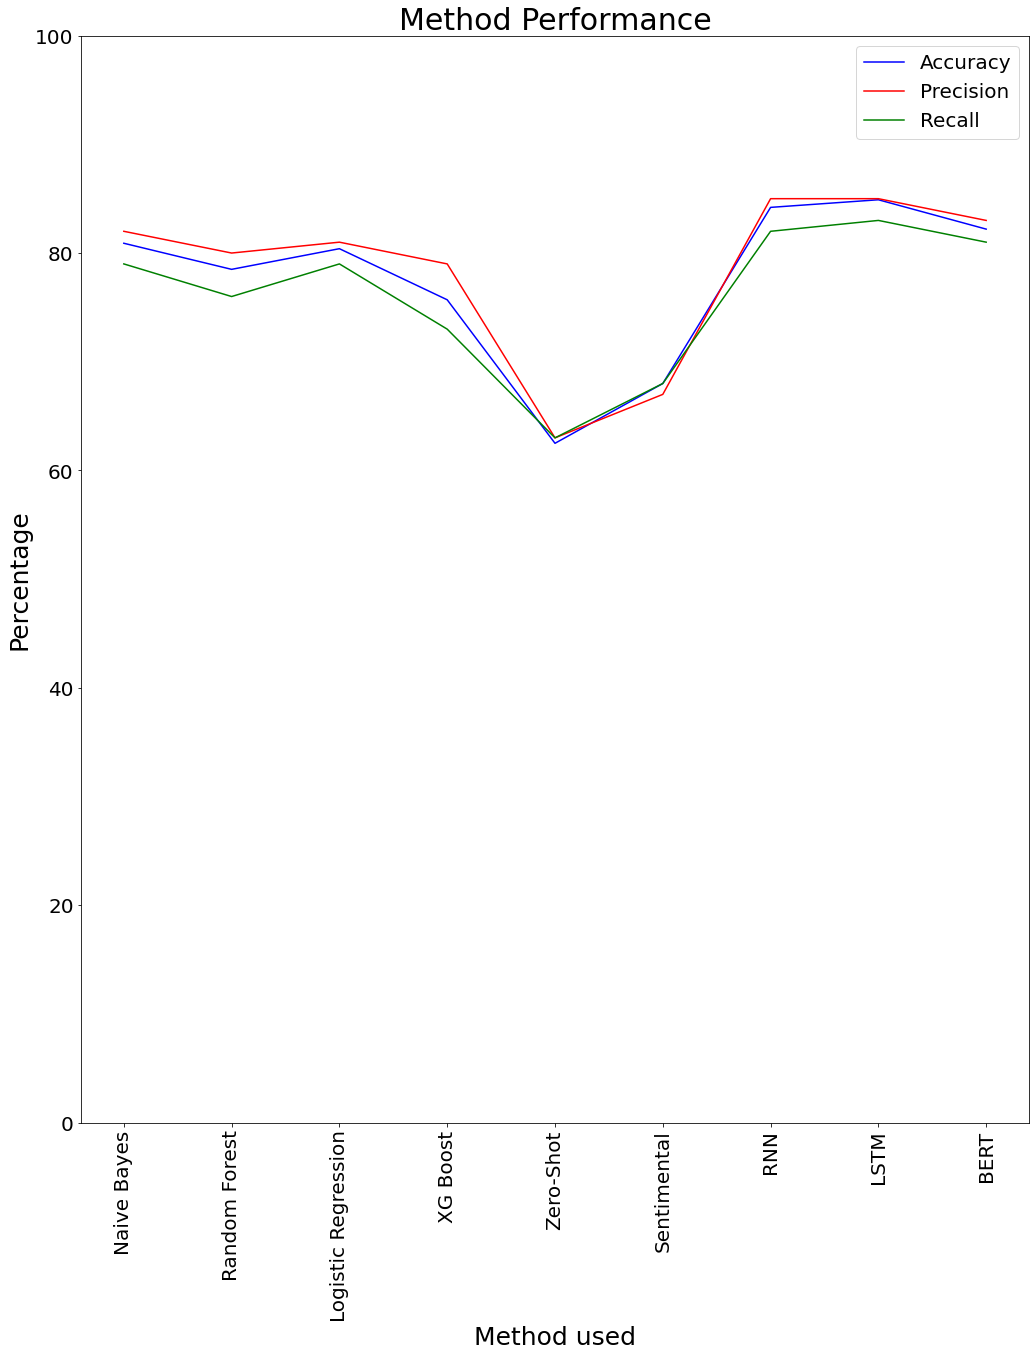

In [ ]:
ax = df_res.plot(x='Method', y=['Accuracy', 'Precision', 'Recall'], color=['blue', 'red', 'green'], figsize=(17, 20), fontsize=10)
ax.set_title('Method Performance', fontsize=30)
ax.set_ylabel('Percentage', fontsize=25)
ax.set_xlabel('Method used', fontsize=25)
ax.tick_params(axis='both', labelsize=20)
plt.xticks(rotation=90)
ax.set_ylim([0, 100])
plt.legend(fontsize=20)